In [ ]:
%matplotlib inline


#for sample training of this network, only the first 10000 events will be used

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Iterable, List
from timeit import default_timer as timer

import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor

np.random.seed(0)
torch.manual_seed(0)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
#summary.npz contains the first 10,000 datapoint in the following format
#ith data: x: summary[2*i], y: summary[2*i+1]

In [ ]:
#convert data into images
from numpy import load
FILE = "summary.npz"
data = load(FILE)


training_size = 10000

'''
the images will contain 2 channels as input
channel 1: momentum
channel 2: energy

each image will be 40x40
momentum and energy will be sumed if they are in the same eta/phi square
'''

image_size = 40

etaMin = 100000.0
etaMax = -100000.0
phiMin = 100000.0
phiMax = -100000.0

#function to scale data
def scale_data(arr):
  etaMin = 100000.0
  etaMax = -100000.0
  phiMin = 100000.0
  phiMax = -100000.0
  if(len(arr)!=0):
      scaled_data = np.zeros((len(arr), len(arr[0])))
  else:
      return []

    #iterate each column
  for col_num in range(5):
        #iterate through each element in the column by its row number

      for row_num in range(len(arr)):

        scaled_data[row_num][col_num] = arr[row_num][col_num]

        if(col_num == 1): #eta column
          etaMin = min(etaMin, scaled_data[row_num][col_num])
          etaMax = max(etaMax, scaled_data[row_num][col_num])

        if(col_num == 2): #phi column
          phiMin = min(phiMin, scaled_data[row_num][col_num])
          phiMax = max(phiMax, scaled_data[row_num][col_num])


  return [scaled_data, etaMin, etaMax, phiMin, phiMax]


numParticle = []
for i in range(5):
  numParticle.append(0)


averagedMomentum = []
averagedEnergy = []
for z in range(6):
  averagedMomentum.append([])
  averagedEnergy.append([])
  for i in range(image_size):

    averagedMomentum[z].append([])
    averagedEnergy[z].append([])

    for j in range(image_size):
      averagedMomentum[z][i].append(0)
      averagedEnergy[z][i].append(0)
def convertToImage(arr, typeParticle):
  #standardize eta and phi column
  scaled_data_minmax = scale_data(arr)
  arr = scaled_data_minmax[0]
  etaMin = scaled_data_minmax[1]
  etaMax = scaled_data_minmax[2]
  phiMin = scaled_data_minmax[3]
  phiMax = scaled_data_minmax[4]

  #eta/phi change to image_size
  etaStep = (etaMax - etaMin)/float(image_size-1)
  phiStep = (phiMax - phiMin)/float(image_size-1)

#initialize with all zeros
  retMomentum = []
  retEnergy = []
  for i in range(image_size):

    retMomentum.append([])
    retEnergy.append([])

    for j in range(image_size):
      retMomentum[i].append(0)
      retEnergy[i].append(0)
  #change eta/phi to current
  for i in range(1, 3):
    for row_num in range(len(arr)):
      if(i==1):
        if(etaStep!=0):
          arr[row_num][i] = int((arr[row_num][i]-etaMin)/etaStep)
        else:
          arr[row_num][i] = 0
      if(i==2):
        if(phiStep!=0):
          arr[row_num][i] = int((arr[row_num][i]-phiMin)/phiStep)
        else:
          arr[row_num][i] = 0
   #sum up energy and momentum in location
  for row_num in range(len(arr)):
    x, y = int(arr[row_num][1]), int(arr[row_num][2])

    retMomentum[x][y] += arr[row_num][0]
    averagedMomentum[0][x][y] += arr[row_num][0]/(training_size)
    averagedMomentum[typeParticle][x][y] += arr[row_num][0]
    numParticle[typeParticle]+=1;

    retEnergy[x][y] += arr[row_num][3]
    averagedEnergy[0][x][y] += arr[row_num][3]/(training_size)
    averagedEnergy[typeParticle][x][y] += arr[row_num][3]


  return [retMomentum, retEnergy]

i = 0
training = []
target = []

while(i < training_size):
  cur = data["arr_" + str(2*i)]
  typeParticle = 0
  for j in range(5):
    if data["arr_" + str(2*i+1)][j] == 1:
      typeParticle = j

  cur = convertToImage(cur, typeParticle)

  training.append(cur)
  target.append(data["arr_" + str(2*i+1)])
  i = i + 1


for i in range(5):
  for j in range(image_size):
    for z in range(image_size):
      averagedMomentum[i+1][j][z] /= numParticle[i]
      averagedEnergy[i+1][j][z] /= numParticle[i]

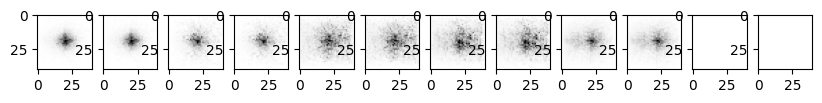

In [ ]:
#visualize model
plt.figure(figsize = (10, 10))

plt.subplot(1,12,1)


for i in range(6):
  plt.subplot(1, 12, 2*i + 1)
  plt.imshow(averagedMomentum[i], cmap = 'Greys')

  plt.subplot(1, 12, 2*i + 2)
  plt.imshow(averagedEnergy[i], cmap = 'Greys')


In [ ]:
for i in numParticle:
  print(i, end = ' ')

137927 81068 82378 82448 133561 

# Define Model

In [ ]:
class CNNModel(torch.nn.Module):

    def __init__(self):

        super(CNNModel, self).__init__()

        # YOUR CODE HERE
        self.cnn1 = torch.nn.Conv2d(in_channels = 2,
                                    out_channels = 56, kernel_size = 3,
                                    stride = 1, padding = 0)

        self.maxpool1 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.dropout = torch.nn.Dropout(p=0.1)

        self.cnn2 = torch.nn.Conv2d(in_channels = 56, out_channels = 16,
                                    kernel_size = 2, stride = 1, padding = 0)

        self.maxpool2 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = torch.nn.Linear(9*9*16, 256)

        self.fc2 = torch.nn.Linear(256, 50)

        self.fc3 = torch.nn.Linear(50, 10)

        self.output_layer = torch.nn.Linear(10, 5)

    def forward(self, x):

        # YOUR CODE HERE
        # Note: If you are using CrossEntropyLoss() do NOT apply softmax to the final ouput
        # since it's incorporated within the loss function
        # input image -> conv1 -> relu -> maxpool1
        conv1_out = torch.nn.functional.relu(self.cnn1(x))
        pool1_out = self.maxpool1(conv1_out)

        conv2_out = torch.nn.functional.relu(self.cnn2(pool1_out))
        pool2_out = self.maxpool2(conv2_out)

        fcn_input = pool2_out.view(pool2_out.size(0), -1)

        layer_fc1 = torch.nn.functional.relu(self.fc1(fcn_input))
        layer_fc1 = self.dropout(layer_fc1)
        layer_fc2 = torch.nn.functional.relu(self.fc2(layer_fc1))

        layer_fc3 = torch.nn.functional.relu(self.fc3(layer_fc2))
        output = self.output_layer(layer_fc3)

        return output

In [ ]:
torch.manual_seed(55)

model = CNNModel()

learning_rate = 0.01
epochs = 50
batchsize = 1000

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model

CNNModel(
  (cnn1): Conv2d(2, 56, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (cnn2): Conv2d(56, 16, kernel_size=(2, 2), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1296, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=5, bias=True)
)

In [ ]:
validation = training[:1000]
validation_target = target[:1000]
training = training[1000:]
training_target = target[1000:]
batch_split_num = len(target)//(batchsize)

training = torch.from_numpy(np.array(training)).float()
training_target = torch.from_numpy(np.array(training_target)).float()
validation = torch.from_numpy(np.array(validation)).float()
validation_target = torch.from_numpy(np.array(validation_target)).float()

train_batches = torch.split(training, batchsize)
target_batches = torch.split(training_target, batchsize)
batch_split_num = len(train_batches)

train_loss_list = np.zeros(epochs*batch_split_num)# YOUR CODE HERE
validation_accuracy_list = np.zeros(epochs*batch_split_num)

for epoch in range(epochs):

    # YOUR CODE HERE
    for k in range(batch_split_num):

      optimizer.zero_grad()

      train_batch_outputs = model(train_batches[k])
      loss = loss_func(train_batch_outputs, target_batches[k])

      train_loss_list[epoch * batch_split_num + k] = (loss.item())

      loss.backward()
      optimizer.step()

    with torch.no_grad():
      validation_outputs = model(validation)

      cur_predict = torch.argmax(validation_outputs, dim = 1)
      correct = torch.argmax(validation_target, dim = 1)


      num_correct = 0
      for z in range(len(validation_outputs)):
        if(cur_predict[z] == correct[z]):
          num_correct+=1


      num_correct /= (len(validation_outputs))


      print("Epoch: {}, Validation Accuracy: {}%".format(epoch, np.round(num_correct*100, 2)))
    # YOUR CODE HERE
      validation_accuracy_list[epoch] = num_correct

Epoch: 0, Validation Accuracy: 21.9%
Epoch: 1, Validation Accuracy: 27.8%
Epoch: 2, Validation Accuracy: 25.8%
Epoch: 3, Validation Accuracy: 30.9%
Epoch: 4, Validation Accuracy: 34.9%
Epoch: 5, Validation Accuracy: 36.5%
Epoch: 6, Validation Accuracy: 39.5%
Epoch: 7, Validation Accuracy: 39.3%
Epoch: 8, Validation Accuracy: 42.4%
Epoch: 9, Validation Accuracy: 41.2%
Epoch: 10, Validation Accuracy: 41.8%
Epoch: 11, Validation Accuracy: 41.7%
Epoch: 12, Validation Accuracy: 44.3%
Epoch: 13, Validation Accuracy: 44.1%
Epoch: 14, Validation Accuracy: 43.6%
Epoch: 15, Validation Accuracy: 44.0%
Epoch: 16, Validation Accuracy: 41.4%
Epoch: 17, Validation Accuracy: 40.0%
Epoch: 18, Validation Accuracy: 42.0%
Epoch: 19, Validation Accuracy: 42.8%
Epoch: 20, Validation Accuracy: 42.8%
Epoch: 21, Validation Accuracy: 41.7%
Epoch: 22, Validation Accuracy: 43.4%
Epoch: 23, Validation Accuracy: 44.2%
Epoch: 24, Validation Accuracy: 45.0%
Epoch: 25, Validation Accuracy: 45.1%
Epoch: 26, Validation 

In [ ]:
category_correct = []
num_category = []
for i in range(5):
  category_correct.append(0)
  num_category.append(0)

with torch.no_grad():
  validation_outputs = model(validation)

  cur_predict = torch.argmax(validation_outputs, dim = 1)
  correct = torch.argmax(validation_target, dim = 1)


  num_correct = 0
  for z in range(len(validation_outputs)):
    if(cur_predict[z] == correct[z]):
       category_correct[correct[z]]+=1
    num_category[correct[z]] += 1


print(category_correct)
print(num_category)

[114, 57, 51, 61, 113]
[198, 184, 207, 192, 219]
